In [1]:
# IMAGE CONFIGURATIONS
IMAGE_SIZE = [299, 299] 

# TRAINING CONFIGURATIONS
epochs = 16
batch_size = 128

## Preparing Data

In [4]:
import pandas as pd
df_train_data = pd.read_csv('data/merged_train.csv')
df_train_data

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4
...,...,...
27048,1778392170.jpg,2
27049,2495608764.jpg,3
27050,698646619.jpg,4
27051,297559984.jpg,3


In [5]:
# Downsampling
import pandas as pd
from sklearn.utils import resample

class_counts = df_train_data['labels'].value_counts()
target_count = class_counts.min()

In [7]:
# Downsample each class to the target count
df_train_data = pd.concat(
    [resample(df_train_data[df_train_data['labels'] == c], 
              replace=False,            # don't sample with replacement
              n_samples=target_count,   # target number of samples
              random_state=42) 
     for c in class_counts.index]
)

# Shuffle the dataset after downsampling
df_train_data = df_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display or save the downsampled dataset
print(df_train_data.head())
# df_downsampled.to_csv('downsampled_dataset.csv', index=False)
label_counts = df_train_data['labels'].value_counts()
print(label_counts)

            image_id  labels
0      935723534.jpg       0
1  train-cbb-305.jpg       0
2  train-cbb-281.jpg       0
3  train-cgm-621.jpg       2
4     2799677142.jpg       2
labels
0    1553
2    1553
4    1553
3    1553
1    1553
Name: count, dtype: int64


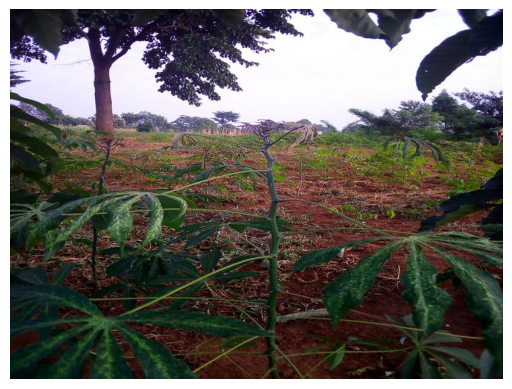

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = '/Users/alexshienhowkhoo/Documents/SC4000 Project/dataset/train_images'

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [13]:
unique_labels = df_train_data.labels.value_counts()
num_unique_labels = unique_labels.index.nunique()

print(unique_labels)
print(num_unique_labels)


labels
0    1553
2    1553
4    1553
3    1553
1    1553
Name: count, dtype: int64
5


In [5]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["label"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [6]:
from torch.utils.data import Dataset
import os 
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [8]:
import torch 
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [9]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 151/151 [01:22<00:00,  1.83it/s]


In [10]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])
train_df = ConstDataset(df_train, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [11]:
# trainloader = torch.utils.data.DataLoader(train_df, batch_size=4,
#                                           shuffle=True, num_workers=0)
# torch.manual_seed(124)
# for batch_idx, data in enumerate(trainloader,0):
#     if(batch_idx==0): 
#         input, label = data 
#         print(type(input))
#         print(input[0].shape)
#         print(input[0])
#         plt.imshow(input[0].numpy().transpose(1,2,0))
#     break;



In [12]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [13]:
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [14]:
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn
import torch.optim as optim

weights = Inception_V3_Weights
model = inception_v3(weights=weights)
num_classes = num_unique_labels
model.fc = nn.Linear(model.fc.in_features, num_classes)


/Users/alexshienhowkhoo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [16]:
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
# MODIFICATIONS
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


In [17]:
!pip install tensorflow-macos


   ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 131.9/227.0 MB 1.1 MB/s eta 0:01:24m^C
   ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 132.1/227.0 MB 1.1 MB/s eta 0:01:23
ERROR: Operation cancelled by user


In [84]:
!pip install tensorflow-macos


In [85]:
# Define device (MPS or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

In [86]:
for epoch in range(epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs, labels = inputs.to(device),labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            #MODIFICATIONS
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
  
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.float() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.float() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.1064 Acc: 0.6093
val Loss: 0.9927 Acc: 0.6234
train Loss: 0.9775 Acc: 0.6427
val Loss: 0.9190 Acc: 0.6505
train Loss: 0.9265 Acc: 0.6607
val Loss: 0.8774 Acc: 0.6771
train Loss: 0.8988 Acc: 0.6686
val Loss: 0.8632 Acc: 0.6785
train Loss: 0.8799 Acc: 0.6787
val Loss: 0.8496 Acc: 0.6752
train Loss: 0.8652 Acc: 0.6821
val Loss: 0.8332 Acc: 0.6972
train Loss: 0.8549 Acc: 0.6860
val Loss: 0.8133 Acc: 0.7037
train Loss: 0.8452 Acc: 0.6879
val Loss: 0.8071 Acc: 0.7061
train Loss: 0.8394 Acc: 0.6903
val Loss: 0.8058 Acc: 0.7023
train Loss: 0.8391 Acc: 0.6910
val Loss: 0.7921 Acc: 0.7164
train Loss: 0.8347 Acc: 0.6921
val Loss: 0.7995 Acc: 0.7065
train Loss: 0.8306 Acc: 0.6917
val Loss: 0.7893 Acc: 0.7089
train Loss: 0.8261 Acc: 0.6950
val Loss: 0.7889 Acc: 0.7210
train Loss: 0.8265 Acc: 0.6955
val Loss: 0.7812 Acc: 0.7178
train Loss: 0.8210 Acc: 0.6954
val Loss: 0.7799 Acc: 0.7154
train Loss: 0.8195 Acc: 0.6988
val Loss: 0.7775 Acc: 0.7145
Training complete!


In [87]:
# Define the path where you want to save the model
save_path = './trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ./trained_model.pth


In [88]:
#https://pytorch.org/vision/0.9/models.html